<a href="https://colab.research.google.com/github/pragy19/StressDetection/blob/main/stress_xgboost(time_domain_and_freq_domain_features).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_auc_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [ ]:
# Step 2: Load Combined Dataset
old_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stress/train.csv")
test1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stress/test.csv")
new_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stress/new_train.csv")
test2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stress/new_test.csv")


In [ ]:
# Step 3: Rename Condition Column to Label
for df in [old_train, new_train, test1, test2]:
    df.rename(columns={'condition': 'label'}, inplace=True)

In [ ]:

# Step 4: Define Core Features (including new time-domain features)
# Step 4: Define Full Feature Set (Time + Frequency Domain)
core_features = [
    'MEAN_RR', 'SDRR', 'RMSSD', 'HR', 'pNN25', 'pNN50',
    'VLF', 'LF', 'HF', 'LF_HF'
]

# Combine training data
X_train_combined = pd.concat([old_train[core_features], new_train[core_features]], axis=0)
y_train_combined = pd.concat([old_train['label'], new_train['label']], axis=0)

# Combine test data
X_test_combined = pd.concat([test1[core_features], test2[core_features]], axis=0)
y_test_combined = pd.concat([test1['label'], test2['label']], axis=0)



In [ ]:
# Print first 5 rows of training features
print("🔹 X_train_combined:")
print(X_train_combined.head())

# Print first 5 labels of training
print("\n🔹 y_train_combined:")
print(y_train_combined.head())

🔹 X_train_combined:
      MEAN_RR        SDRR      RMSSD         HR      pNN25     pNN50  \
0  885.157845  140.972741  15.554505  69.499952  11.133333  0.533333   
1  939.425371   81.317742  12.964439  64.363150   5.600000  0.000000   
2  898.186047   84.497236  16.305279  67.450066  13.066667  0.200000   
3  881.757865   90.370537  15.720468  68.809562  11.800000  0.133333   
4  809.625331   62.766242  19.213819  74.565728  20.200000  0.200000   

           VLF           LF         HF       LF_HF  
0  2661.894136  1009.249419  15.522603   65.018055  
1  2314.265450   690.113275   2.108525  327.296635  
2  1373.887112  1298.222619  13.769729   94.280910  
3  2410.357408  1005.981659  18.181913   55.328701  
4  1151.177330  1421.782051  48.215822   29.487873  

🔹 y_train_combined:
0       no stress
1    interruption
2    interruption
3       no stress
4       no stress
Name: label, dtype: object


In [ ]:
# Step 5: Encode Labels (ensure consistency)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_combined)
y_test_encoded = label_encoder.transform(y_test_combined)


In [ ]:
# Step 6: Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

In [ ]:
# Step 7: Handle Class Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_encoded)

In [ ]:
# Step 8: Split into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)

In [ ]:
# Step 9: Compute Class Weights
sample_weights = compute_sample_weight('balanced', y_train)

In [ ]:
# Step 10: Define XGBoost Model
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

In [ ]:
# Step 11: Fit the Model with Sample Weights
model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=True
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.92010
[1]	validation_0-mlogloss:0.80430
[2]	validation_0-mlogloss:0.71839
[3]	validation_0-mlogloss:0.65105
[4]	validation_0-mlogloss:0.59500
[5]	validation_0-mlogloss:0.54617
[6]	validation_0-mlogloss:0.50373
[7]	validation_0-mlogloss:0.47289
[8]	validation_0-mlogloss:0.43531
[9]	validation_0-mlogloss:0.40583
[10]	validation_0-mlogloss:0.37653
[11]	validation_0-mlogloss:0.35920
[12]	validation_0-mlogloss:0.34350
[13]	validation_0-mlogloss:0.32745
[14]	validation_0-mlogloss:0.30577
[15]	validation_0-mlogloss:0.29633
[16]	validation_0-mlogloss:0.28212
[17]	validation_0-mlogloss:0.26696
[18]	validation_0-mlogloss:0.25695
[19]	validation_0-mlogloss:0.25158
[20]	validation_0-mlogloss:0.24391
[21]	validation_0-mlogloss:0.22977
[22]	validation_0-mlogloss:0.22117
[23]	validation_0-mlogloss:0.21176
[24]	validation_0-mlogloss:0.20583
[25]	validation_0-mlogloss:0.19653
[26]	validation_0-mlogloss:0.18738
[27]	validation_0-mlogloss:0.17927
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [ ]:
# Step 12: Evaluate Model
# Predict on test data
y_test_pred = model.predict(X_test_scaled)

# Classification Report
class_report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_)
print("\nClassification Report:\n", class_report)



Classification Report:
                precision    recall  f1-score   support

 interruption       1.00      0.99      0.99     22897
    no stress       1.00      1.00      1.00     43468
time pressure       0.97      1.00      0.99     13832

     accuracy                           1.00     80197
    macro avg       0.99      0.99      0.99     80197
 weighted avg       1.00      1.00      1.00     80197



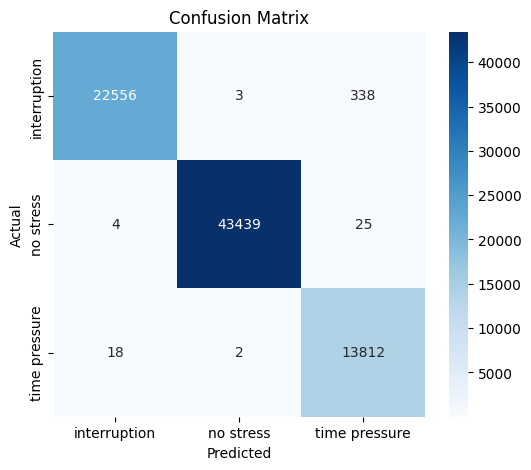

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

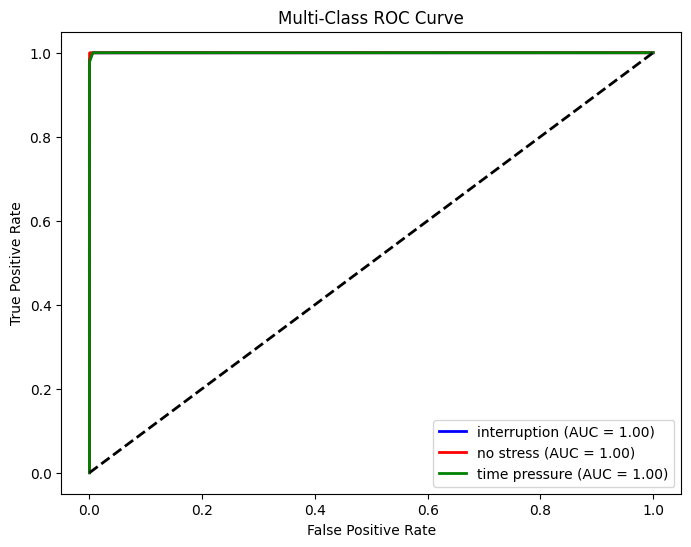

In [ ]:
# Step 13: ROC Curve and AUC for Multi-Class
# Binarize labels for ROC curve calculation
y_test_bin = label_binarize(y_test_encoded, classes=np.arange(len(label_encoder.classes_)))
y_pred_proba = model.predict_proba(X_test_scaled)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
class_names = label_encoder.classes_
for i, color in zip(range(y_test_bin.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')


# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Step : Overall AUC Score
overall_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro')
print(f"\nOverall Test AUC: {overall_auc:.4f}")



Overall Test AUC: 1.0000


In [ ]:
# Step 14: Save Model and Scaler
model.save_model('/content/drive/MyDrive/Colab Notebooks/stress/video/last.json')
joblib.dump(scaler, '/content/drive/MyDrive/Colab Notebooks/stress/video/last.pkl')
print("\n✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [ ]:
# Step 15: Validation and Test Accuracy
# Predict on validation data
y_val_pred = model.predict(X_val)

# Calculate validation accuracy
val_acc = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_acc:.4f}")

# Predict on test data
y_test_pred = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")


Validation Accuracy: 0.9952
Test Accuracy: 0.9951
